<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### As usually let's do some imports and define global constants

In [2]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, LSTM, GRU, Embedding, RepeatVector, Lambda, Reshape
from keras.layers import Bidirectional as Bi
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

EPOCHES = 100
BS = 512

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Let's look at the data in given file

In [3]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [4]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


### Let's look at some sentences


In [5]:
a,b,c = np.random.choice(len(rus_trn), 3)

print(rus_trn[a][0])
print(rus_trn[a][1])
print(rus_trn[b][0])
print(rus_trn[b][1])
print(rus_trn[c][0])
print(rus_trn[c][1])

веб-операторы обязаны ознакомить пользователя с политикой по сбору персональной информации
%% v' 'e1 p a' p' 'i r a1 t ax r ax # a' b' 'a1 z ax n ax # a z n a k o'1 m' 'ix' t' # p o'1 l' z ax v ax' t' 'ix' l' 'ax # s _ p a' l' 'i'1 t' 'ix k ax' j' # p a _ z b o1 r ux' # p' 'ix r s a n a'1 l' n ax' j' # 'i n f a r m a1 ts ax' i %%
цена мартовского контракта на нефть в торговой системе поднялась
%% ts y n a1 # m a1 r t ax f s k ax v ax # k a n t r a1 k t ax # n a' _ n' 'e1 f t' # f _ t a r g o1 v ax' j' # s' 'i' s' t' 'e'1 m' 'ix # p ax' d' n' 'i l a'1 s' %%
в августе прошлого года был достроен храм христа спасителя
%% v _ a1 v g ux' s' t' 'ix # p r o1 sh l ax v ax # g o1 d ax # b y1 l # d a s t r o'1 jax n # h r a1 m # h r' 'i s t a1 # s p a' s' 'i'1 t' 'ix' l' 'a %%


### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


### Let's see if we have dupliates in the corpus

In [0]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in the corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

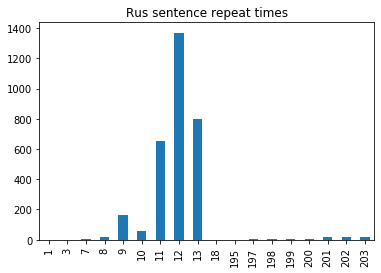

In [0]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the tokens. We'll count the tokens in each sentence. If the count in rus and trans is different, we'll record it as anomaly


149   невостребованных талантов в стране уйма
%% n' 'ix v a s t r' 'e1 b ax v ax n n ax h # t a l a1 n t ax f # f s t r a' n' 'e1 # u'1 j' m a %%
336   в срок платежа денежные средства перечислены не были
%% f _ s r o1 k # p l ax' t' 'i zh a'1 # d' 'e'1 n' 'ix zh n ax' jax # s r' 'e1 ts t v ax' # p' 'ix' r' 'i' ch' 'i1 s l' 'ix n ax' # n' 'e1 b ax' l' 'i %%
772   дружба обеих корей может прекратиться так же неожиданно как и началась
%% d r u1 zh b ax # a' b' 'e'1 i h # k a' r' 'e'1 j' # m o1 zh ax t # p r' 'ix k r a' t' 'i1 ts ts ax # t a1 g zh ax' # n' 'ixa zh y1 d ax n n a %% %% k a1 k # y _ n ax' ch' 'i l a'1 s' %%
858   если окутать ёлку дождиком она получится как бы в дымке
%% j' 'e1 s l' 'ix # a k u1 t ax' t' # j' 'o1 l k ux # d o1 zh d' 'ix k ax m %% %% a n a1 # p a l u'1 ch' 'ix ts ts ax # k a1 g b ax # v _ d y1 m k' 'e %%
868   королёв в тюрьме сделал свои первые рисунки ракеты
%% k ax r a' l' 'o1 f # f t' 'u' r' m' 'e'1 # z' d' 'e1 l ax l # s v a' i'1 # p' 'e1 r v ax' jax' # 

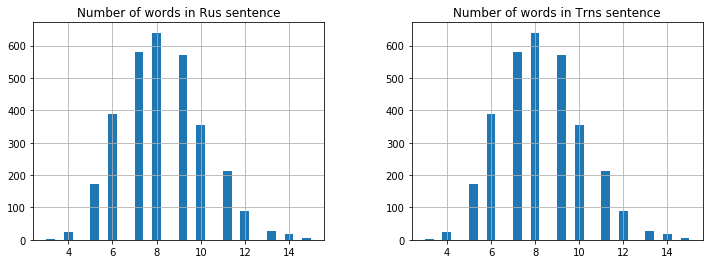

In [0]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):

  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
      print(j, ' ', i[0])
      print( i[1])
    
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

### So we have 49 anomalies out of 3131 samples

### Closer look at the anomalies shows:
* Particles 'же', 'бы', 'ли' never get separated as a standalone word in transcript. Hypothesis: glue the particle to the preceeding token during prepocessing
* There are 10 cases where 'не был(о/а/и)' result in joint transcript. Hypothesis: put 'не был(а/а/и)' as one token during prepocessing
* Remaining 15 anomalies seem to be errors or typos

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


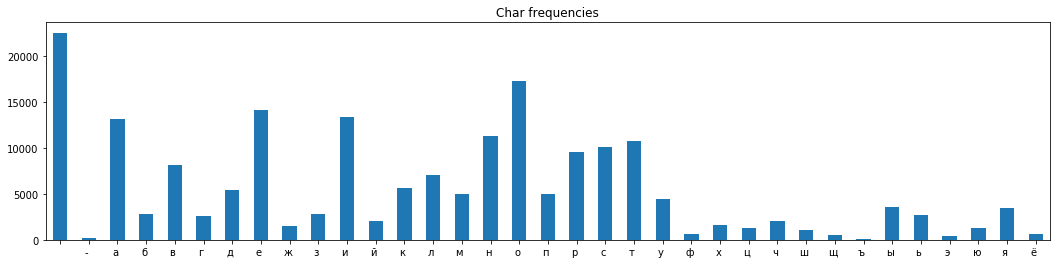

In [0]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [0]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

### Okey, words with dash look fine, we'll consider dash as a normal letter

### The size of the corpus is too small to tokenize on words. Insted we'll tokenize bsed on characters

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' (treat them as separate token) and remove begin and end markers. Plus to that let's get rid of duplicates.

### Second thought though. Since Russian corpus does not include any punctuation, we cannot predict '%% %%' token properly. So let's sacrifice one token for the sake of overall accuracy meaning that we remove '%% %%' token completely from the corpus


max len rus: 27, max len trn: 26


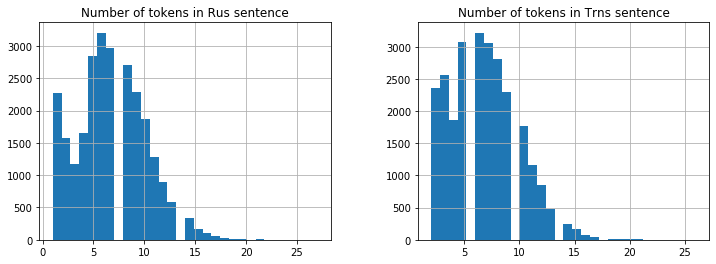

In [11]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []
for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      # let's fix the errors in corpus
      trn = trn.replace("f s t r a' n' 'e1", "f _ s t r a' n' 'e1") \
              .replace("f t' 'u' r' m' 'e'1", "f _ t' 'u' r' m' 'e'1") \
              .replace("f s' 'i' b' 'e1", "f _ s' 'i' b' 'e1") \
              .replace("n' 'e'1 p' 'ix' r' 'ix t k' 'ix m", "n' 'e'1 # p' 'ix' r' 'ix t k' 'ix m") \
              .replace("f p' 'i'1 sh' 'ux", "f _ p' 'i'1 sh' 'ux") \
              .replace("f p l' 'ix' m' 'i n a1 h", "f _ p l' 'ix' m' 'i n a1 h") \
              .replace("k ax n s u' l' 'i1 n u", "k _ ax n s u' l' 'i1 n u") \
              .replace("f k o1 s m ax s", "f _ k o1 s m ax s") \
              .replace("z' d' 'i' j' s t v' 'i'1 t' 'ix' l' n ax' s' t' j' 'u", "z' _ d' 'i' j' s t v' 'i'1 t' 'ix' l' n ax' s' t' j' 'u") \
              .replace("g z ax b a s t o1 f k' 'e", "g _ z ax b a s t o1 f k' 'e") \
              .replace("k m' 'ix s t ax r a zh d' 'e'1 n' 'ix' jax m", "k _ m' 'ix s t ax r a zh d' 'e'1 n' 'ix' jax m") \
              .replace("f k a n ts e1", "f _ k a n ts e1") \
              .replace("f p' 'i' r' 'i1 o t", "f _ p' 'i' r' 'i1 o t") \
              .replace("f s' 'i k u1 n d u", "f _ s' 'i k u1 n d u") \
              .replace("v' 'i'1 d' 'ixo' i _", "v' 'i'1 d' 'ixo' # i _")

      # '# <PNK>'
      trn = trn[3:-3].replace('%% %%', '#') \
                .replace('_', '_ #') \
                .split('#')

      # let's fix inconsistencies with particles
      rus = rus.replace(' же ', 'же ') \
                .replace(' бы ', 'бы ') \
                .replace(' ли ', 'ли ') \
                .replace(' не был', ' небыл') \
                .split(' ')

      for a,b in zip(rus, trn):
        b = b.strip().split(' ')
        res.append((list(a), b))
        rus_l.append( len(a))
        trn_l.append( len(b))

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
print(f'max len rus: {rus_length}, max len trn: {trn_length}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of tokens in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of tokens in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [0]:
a = np.random.choice(len(rus_trn_new))
rus_trn_new[a]

array([list(['с', 'у', 'щ', 'е', 'м', 'у']),
       list(['s', "u'1", "sh'", "'ix", 'm', 'u'])], dtype=object)

### Let's tokenize the sentences. So a word is a sentence, and thus character is a token




In [12]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', lower=False, split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

rus_tokenizer = tokenization(rus_trn_new[:, 0], split='')
rus_vocab_size = len(rus_tokenizer.word_index) + 1
trn_tokenizer = tokenization(rus_trn_new[:, 1], split=' ')
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')

Rus Vocabulary Size: 35
Trns Vocabulary Size: 115


### Encode sentences, pad them, split to train and test


In [13]:
train, test = train_test_split(rus_trn_new, test_size=0.1, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

a = np.random.choice(len(trainX))
print(a)
print( rus_tokenizer.sequences_to_texts([trainX[a]]) )
print( trn_tokenizer.sequences_to_texts([trainY[a]]) )

18078
['у р о в н я']
["u1 r ax v n' 'ax'"]


### Let's build simple sequential seq2seq model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 27, 512)           17920     
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 26, 512)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 26, 512)           2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 26, 115)           58995     
Total params: 4,275,315
Trainable params: 4,275,315
Non-trainable params: 0
_________________________________________________________________
Train on 23461 samples, validate on 2607 samples
Epoch 1/100
23461/23461 [==============================] - 10

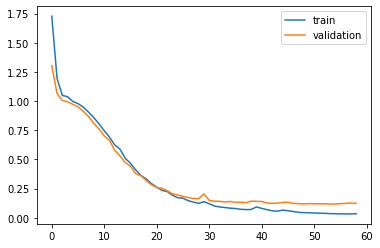

In [16]:
model = Sequential()
model.add(Embedding(rus_vocab_size, 512, input_length=rus_length, mask_zero=True))
model.add(LSTM(512))
model.add(RepeatVector(trn_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(trn_vocab_size, activation='softmax'))
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize defined model
model.summary()

def train_model(model):
  monitor = 'val_acc'
  mode = 'max'
  early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode, restore_best_weights=True)

  data = trainX, [trainY.reshape(*trainY.shape, 1)]
  validation_data = testX, [testY.reshape(*testY.shape, 1)]

  history = model.fit(*data, 
            epochs=EPOCHES, batch_size=BS, 
            validation_data=validation_data,
            callbacks=[early_stop], verbose=1)

  # plot validation loss vs training loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train','validation'])
  plt.show()

train_model(model)

### accuracy on validation set is 0.9662 - Not bad for the first model! Let's see if we could improve that further more

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 27, 512)      17920       input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 1024), (None 4198400     embedding_7[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 1024)         0           bidirectional_1[0][0]            
____________________________________________________________________________________________

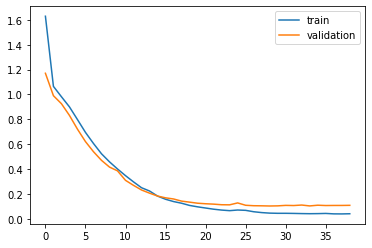

In [17]:
def define_seq2seq_BiLSTM(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c, h2, c2 = Bi(LSTM(units, return_state=True))(x)
  x = Dropout(0.1)(x)
  x = RepeatVector(out_timesteps)(x)
  x = Bi(LSTM(units, return_sequences=True))(x, initial_state = (h, c, h2, c2))
  x = Dropout(0.1)(x)
  output = Dense(out_vocab, activation='softmax')(x)
  model = Model(input, output)
  model.summary()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = define_seq2seq_BiLSTM(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
train_model(model)

### val_acc: 0.9699 = Bidirectional LSTM with states transfer slightly improves the result. What's next? Let's try 2 layers of LSTM in encoder-decoder

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 27, 512)      17920       input_8[0][0]                    
__________________________________________________________________________________________________
lstm_19 (LSTM)                  [(None, 27, 512), (N 2099200     embedding_9[0][0]                
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 27, 512)      0           lstm_19[0][0]                    
____________________________________________________________________________________________

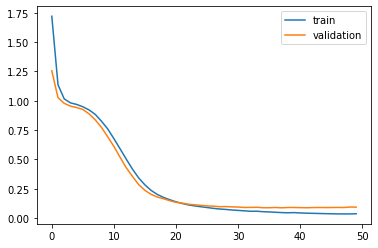

In [19]:
def define_seq2seq_2LSTM(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_sequences=True, return_state=True, go_backwards=True)(x)
  x = Dropout(0.5)(x)
  x, h2, c2 = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  x = Dropout(0.5)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h2, c2))
  output = Dense(out_vocab, activation='softmax')(x)
  model = Model(input, output)
  model.summary()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = define_seq2seq_2LSTM(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
train_model(model)

### val_acc: 0.9745 = Best result so far!

### Now that we've trained our model, let's see how it performs. Let's predict 15 random tokens from the test corpus

In [20]:
a = np.random.choice(len(testX), 15)

x = testX[a]
pred_ohe = model.predict(x, use_multiprocessing=True)
pred = np.argmax(pred_ohe, axis=2)
translation = trn_tokenizer.sequences_to_texts(pred)

pred_df = pd.DataFrame({'actual' : trn_tokenizer.sequences_to_texts(testY[a]), 'predicted' : translation})
pred_df

,actual,predicted
0,d' n' 'o1 m,d' n' 'o1 m
1,zh y'1 z' n',zh y'1 z' n'
2,n a' ch' 'a1 l ax',n a' ch' 'a1 l ax
3,k r y' s' 'i1 n ax' j',k r a' s' 'i1 n ax' j'
4,ji v o1,j' 'i o'1
5,p a' d' n' 'a1 ts ts ax,p a' d' n' 'a1 ts ts ax
6,s k o1 r a,s k o1 r ax
7,n a' m' 'e'1 r' 'ix n,n a' m' 'e'1 r' 'ix n
8,p a' ch' t' 'i1,p a' ch' t' 'i'1
9,y z d a'1 n' 'ix' jax,i z d a'1 n' 'ix' jax


### Now let's put all that together in a function

In [21]:
import string

def make_transctript(str):
  input_string = rus_trn[a][0]
  input_string = input_string.lower()
  input_string = input_string.translate(str.maketrans('', '', string.punctuation))
  input_string = [list(each) for each in input_string.split(' ')]
  input_seq = encode_sequences(rus_tokenizer, rus_length, input_string)

  pred_ohe = model.predict(input_seq, use_multiprocessing=True)
  pred = np.argmax(pred_ohe, axis=2)
  translation = trn_tokenizer.sequences_to_texts(pred)

  translation = '%% ' + ' # '.join(translation) + ' %%'
  translation = translation.replace('_ #', '_')
  return translation.replace('<PNK>', '%% %%')

a = np.random.choice(len(rus_trn))
print(f'Original sentence in Russian (#{a})')
print( rus_trn[a][0])
print('Original transcript')
print( rus_trn[a][1])
print('Predicted transcript')
print( make_transctript( rus_trn[a][0]) )

Original sentence in Russian (#16049)
жизнь в провинции сильно отличается от жизни в москве
Original transcript
%% zh y'1 z' n' # f _ p r a' v' 'i1 n ts ax' i' # s' 'i'1 l' n ax # a t l' 'i' ch' 'a'1 jax ts ts ax # a d _ zh y'1 z' n' 'ix # v _ m a s k v' 'e1 %%
Predicted transcript
%% zh y'1 z' n' # v _ p r a' v' 'i1 n ts ax' i # s' 'i'1 l' n ax # a t l' 'i' ch' 'a'1 jax ts ts ax # a t _ zh y'1 z' n' 'ix # v _ m a s k v' 'e1 %%


### Let's build seq2seq teacher forcing model. First let's prepare the data by modifying target_output and creating target_input

max len rus: 27, max len trn: 26


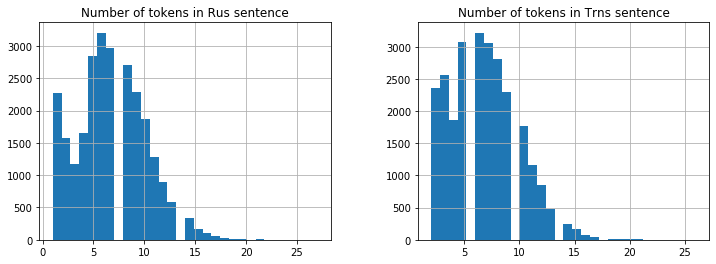

In [27]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []
for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      # let's fix the errors in corpus
      trn = trn.replace("f s t r a' n' 'e1", "f _ s t r a' n' 'e1") \
              .replace("f t' 'u' r' m' 'e'1", "f _ t' 'u' r' m' 'e'1") \
              .replace("f s' 'i' b' 'e1", "f _ s' 'i' b' 'e1") \
              .replace("n' 'e'1 p' 'ix' r' 'ix t k' 'ix m", "n' 'e'1 # p' 'ix' r' 'ix t k' 'ix m") \
              .replace("f p' 'i'1 sh' 'ux", "f _ p' 'i'1 sh' 'ux") \
              .replace("f p l' 'ix' m' 'i n a1 h", "f _ p l' 'ix' m' 'i n a1 h") \
              .replace("k ax n s u' l' 'i1 n u", "k _ ax n s u' l' 'i1 n u") \
              .replace("f k o1 s m ax s", "f _ k o1 s m ax s") \
              .replace("z' d' 'i' j' s t v' 'i'1 t' 'ix' l' n ax' s' t' j' 'u", "z' _ d' 'i' j' s t v' 'i'1 t' 'ix' l' n ax' s' t' j' 'u") \
              .replace("g z ax b a s t o1 f k' 'e", "g _ z ax b a s t o1 f k' 'e") \
              .replace("k m' 'ix s t ax r a zh d' 'e'1 n' 'ix' jax m", "k _ m' 'ix s t ax r a zh d' 'e'1 n' 'ix' jax m") \
              .replace("f k a n ts e1", "f _ k a n ts e1") \
              .replace("f p' 'i' r' 'i1 o t", "f _ p' 'i' r' 'i1 o t") \
              .replace("f s' 'i k u1 n d u", "f _ s' 'i k u1 n d u") \
              .replace("v' 'i'1 d' 'ixo' i _", "v' 'i'1 d' 'ixo' # i _")

      # '# <PNK>'
      trn = trn[3:-3].replace('%% %%', '#') \
                .replace('_', '_ #') \
                .split('#')

      rus = rus.replace(' же ', 'же ') \
                .replace(' бы ', 'бы ') \
                .replace(' ли ', 'ли ') \
                .replace(' не был', ' небыл') \
                .split(' ')

      for a,b in zip(rus, trn):
        b = b.strip().split(' ')
        res.append((list(a) + ['<eos>'], b + ['<eos>'], ['<sos>'] + b))
        rus_l.append( len(a))
        trn_l.append( len(b))

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
print(f'max len rus: {rus_length}, max len trn: {trn_length}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of tokens in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of tokens in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

### Since the data has changed we need to re-tokenize

In [23]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', lower=False, split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

rus_tokenizer = tokenization(rus_trn_new[:, 0], split='')
rus_vocab_size = len(rus_tokenizer.word_index) + 1
rus_trn_new[0, 1] += ['<sos>']
trn_tokenizer = tokenization(rus_trn_new[:, 1], split=' ')
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')

Rus Vocabulary Size: 36
Trns Vocabulary Size: 117


### ...and now re-split the data

In [24]:
train, test = train_test_split(rus_trn_new, test_size=0.1, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
trainX_ = encode_sequences(trn_tokenizer, trn_length, train[:, 2])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
testX_ = encode_sequences(trn_tokenizer, trn_length, test[:, 2])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

a = np.random.choice(len(trainX))
print(a)
print( rus_tokenizer.sequences_to_texts([trainX[a]]) )
print( trn_tokenizer.sequences_to_texts([trainY[a]]) )
print( trn_tokenizer.sequences_to_texts([trainX_[a]]) )

2987
['т е ч е н и е <eos>']
["t' 'i' ch' 'e'1 n' 'ix' jax <eos>"]
["<sos> t' 'i' ch' 'e'1 n' 'ix' jax"]


### Now let's define the model(s) and train it

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 27, 512)      18432       input_13[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 26, 512)      59904       input_14[0][0]                   
___________________________________________________________________________________________

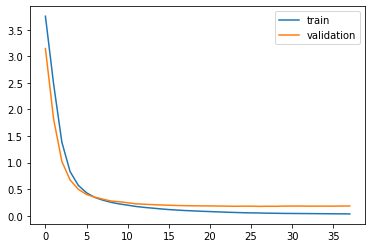

In [28]:
def define_teacher_forcing(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  #train model
  # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, h, c = LSTM(units, return_state=True)(encoder)
  encoder_states = [h, c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference models
  # encoder
  encoder_model = Model(encoder_inputs, encoder_states)
  # decoder
  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, h, c = decoder_lstm(decoder, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  
  return model, encoder_model, decoder_model

model, encoder_model, decoder_model = define_teacher_forcing(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
model.summary()
encoder_model.summary()
decoder_model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

monitor = 'val_acc'
mode = 'max'
early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode, restore_best_weights=True)

data = [trainX_, trainX_], trainY.reshape(*trainY.shape, 1)
validation_data = [testX_, testX_], testY.reshape(*testY.shape, 1)

history = model.fit(*data, 
          epochs=EPOCHES, batch_size=BS, 
          validation_data=validation_data,
          callbacks=[early_stop], verbose=1)

# plot validation loss vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Strangely enough the result of teacher forcing is worse then sequential seq2seq (val_acc: 0.9543 vs val_acc: 0.9662)

In [29]:
a = np.random.choice(len(testX), 1)
translation = []
for i in a:
  input_seq = testX[i]
  states_value = encoder_model.predict(input_seq, use_multiprocessing=True)
  target_seq = np.zeros((1,trn_length))
  target_seq[0, 0] = trn_tokenizer.word_index['<sos>']
  eos = trn_tokenizer.word_index['<eos>']
  output_sentence = []
  p = testY[i]
  for j in range(trn_length):
      pred_ohe, h, c = decoder_model.predict([target_seq] + states_value, use_multiprocessing=True)
      idx = np.argmax(pred_ohe[0, 0, :])
      if idx in [eos, 0]: break

      if idx not in [0] :
        token = trn_tokenizer.index_word[idx]
        output_sentence.append(token)

      target_seq[0, 0] = p[j]
      states_value = [h, c]

  translation = ' '.join(output_sentence)
  print(translation)

pred_df = pd.DataFrame({'actual' : trn_tokenizer.sequences_to_texts(testY[a]), 'predicted' : translation})
pred_df

v v


,actual,predicted
0,s ax g l a sh e'1 n' 'ix' jax <eos>,v v


### The prediction results are disappointing

### So the best model is  [4 layers (2 decoder, 2 encoder) 512 LSTM seq2seq](#scrollTo=LksHo8BAGep9) model with reveresed input on the first layer. Note that clearing and altering the input data helped a lot to get accuracy down to 0.9745